In [5]:
# embedding analysis


# get embeddings of same words
# compare that with other different word
# look at the variance too?


In [83]:
# read all the words and save in a a datastructure
# dictionary with array?

# readin and append to 
# similar technique to what I did for dataset
# calculate offset for file and save
# No we don't even need this thing
# Then just read through each txt file and record the mapping-> easy peasy
# default dict withl list and keep appending
# check simple anaylsis on most common words
# check for its variance compared to randomly chosen word

In [84]:
import os
import numpy as np
import torch
import torch.nn as nn

from collections import defaultdict
from IPython.display import Audio
from python_speech_features import mfcc
from model import *



In [85]:
def create_word_mapper(data_dir, word_dir):
    mapper = defaultdict(list)
    mapper['meta'] = [data_dir, word_dir]
    
    fns = [npz[: -4] for npz in os.listdir(data_dir) if npz[-4: ] == '.npz']
    
    for fn in fns:
        data = np.load(os.path.join(data_dir, f'{fn}.npz'))
        with open(os.path.join(word_dir, f'{fn}.txt'), 'r') as txt:
            ws = txt.read().split()
        for i, w in enumerate(ws):
            mapper[w].append((fn, i))
    return mapper


# def word2wav(word, idx, mapper):
#     """Helper function for get_embedding"""
#     data_dir = mapper['meta'][0]
#     fn, i = mapper[word.upper()][idx]
#     wav = np.load(os.path.join(data_dir, f'{fn}.npz'))[f'arr_{i}']
#     return wav

def get_embedding(word, model, mapper, method='all'):
    """
    Parameter:
        method - one of the followings: 'all', 'average', 'first'
    """
    assert method in ['all', 'average', 'first'], f"{method} is invalid option"
    assert word.isupper(), f"{word} should be all upper case"
    assert word in mapper, f"{word} does not exist in mapper"
    
    data_dir, word_dir = mapper['meta'][0], mapper['meta'][1]
    wavs = []
    for fn, i in mapper[word]:
        wav = np.load(os.path.join(data_dir, f'{fn}.npz'))[f'arr_{i}']
        wavs.append(wav)
        if method == 'first':
            break
    
    x_n = [torch.tensor(mfcc(wav)).float() for wav in wavs]
    embedding = model.embed(x_n)
    if method == 'average':
        embedding = embedding.mean(dim=0, keepdim=True)
    return embedding
    

In [92]:
mapper = create_word_mapper('data/', 'data_mapping/')
data_dir, word_dir = mapper['meta'][0], mapper['meta'][1]

boys = mapper['BOY']
fn, i = boys[1]
wav = np.load(os.path.join(data_dir, f'{fn}.npz'))[f'arr_{i}']
Audio(wav, rate=16000)

In [87]:
model = Speech2Vec().float()
ckpt = torch.load('ckpt/50.pt')
model.load_state_dict(ckpt['state_dict'])


<All keys matched successfully>

In [88]:
# sample_words = ['BOY', 'GIRL', 'LOVE', 'LIKE', 'HAPPY', 'MAN', 'WOMAN']
sample_words = ['BOY', 'GIRL', 'MAN', 'WOMAN']
sample_embs = []

In [13]:
for w in sample_words:
    print(len(mapper[w]))

26
16
88
21


In [14]:
for w in sample_words:
    emb = get_embedding(w, model, mapper, method='average')
    sample_embs.append(emb)


In [15]:
embs = torch.cat(sample_embs, dim=0).numpy()
print(embs.shape)

(4, 50)


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)



In [17]:
p_emb = pca.fit_transform(embs)

In [18]:
import matplotlib.pyplot as plt


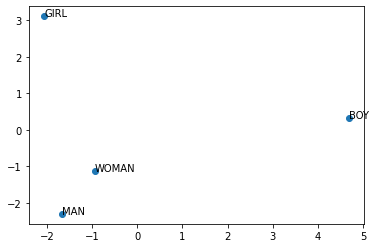

In [19]:
plt.scatter(p_emb[:, 0], p_emb[:, 1])
# annotate
for i, w in enumerate(sample_words):
    plt.annotate(w, (p_emb[i, 0], p_emb[i, 1]))

In [7]:
plt.scatter(p_emb[: boy.size(0), 0], p_emb[: boy.size(0), 1])
plt.scatter(p_emb[boy.size(0): , 0], p_emb[boy.size(0): , 1])

NameError: name 'plt' is not defined

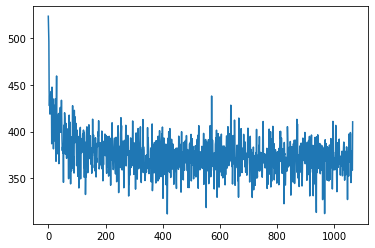

In [10]:
plt.plot(ckpt['losses'])

In [58]:

model = Speech2Vec().float()
ckpt = torch.load('ckpt/50.pt')
model.load_state_dict(ckpt['state_dict'])
word = get_embedding('HE', model, mapper, method='all')
# word2 = get_embedding('THAT', model, mapper, method='all')


std = word.std(dim=0).mean()
std

tensor(1.7722)

(array([ 13.,  37.,  78., 134., 112., 121.,  89.,  31.,  18.,   9.]),
 array([-2.8715832 , -1.3859986 ,  0.09958611,  1.5851707 ,  3.0707555 ,
         4.55634   ,  6.041925  ,  7.527509  ,  9.013094  , 10.498679  ,
        11.984263  ], dtype=float32),
 <BarContainer object of 10 artists>)

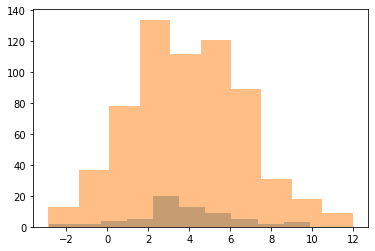

In [42]:
# plt.xlim(-10, 10)
i = 30
plt.hist(word[:, i].numpy(), alpha=0.5)
plt.hist(word2[:, i].numpy(), alpha=0.5)

In [43]:
model()

TypeError: forward() missing 2 required positional arguments: 'ctr' and 'ctxs'

In [44]:
from dataset import *

dataset = LibriSpeechDataset('data/', 'data_mapping/')


100%|█████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 290.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 272.43it/s]


In [46]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=1, collate_fn=dataset.collate_fn, shuffle=True)
src, tgt, w, ws = next(iter(dataloader))
w, ws

(['BUT'],
 [['BOY'], ['AND'], ['BLUNDERBUSS'], ['THAT'], ['REQUIRED'], ['FETCHING']])

In [6]:
import random

teacher_forcing = random.uniform(0, 1) < 0.2

In [47]:
out = model(src, tgt)
itr = iter(range(6))

ValueError: operands could not be broadcast together with shapes (15,13) (14,13) 

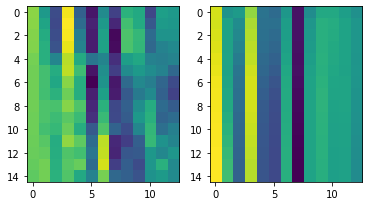

In [49]:
fig, axs = plt.subplots(ncols=2)
i = next(itr)

ttt = tgt[i][0].numpy()
axs[0].imshow(ttt)

asd = out[i][:, 0, :].detach().numpy()
axs[1].imshow(asd)
print(((asd - ttt[: -1]) ** 2).mean(), ((asd - ttt[1:]) ** 2).mean(), ((ttt[:-1] - ttt[1:]) ** 2).mean() )

[tensor(0.3035),
 tensor(0.2907),
 tensor(0.3030),
 tensor(0.2939),
 tensor(0.2963)]

[tensor(0.3005),
 tensor(0.2878),
 tensor(0.3000),
 tensor(0.2910),
 tensor(0.2934)]

# Teacher Forcing Issue
Exposure Bias of ground truth is too strong that it mostly predict itself!

Might have to start training with TF and later learn without TF, or just learn with TF.

Also, I don't know if TF can be used in non-CrossEntropy setting...

# word similarity

using cosine similarity formula


In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [61]:
cosine_similarity

<function sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)>

In [111]:
import pandas as pd
from tqdm import tqdm
import numpy as np

# vecto-ai/word-benchmarks
df = pd.read_csv('mc-30.csv', index_col=0)
import torch

In [90]:


word_set = set(df['word1'].tolist() + df['word2'].tolist())

In [102]:

word_dict = {}
for w in tqdm(word_set):
    try:
        emb = get_embedding(w.upper(), model, mapper, method='average')
    except AssertionError as e:
        print(e)
        emb = torch.zeros((1, 50))
    word_dict[w] = emb

ROOSTER does not exist in mapper


In [128]:

# consine sim
for i, row in df.iterrows():
    if i == 0:
        X = word_dict[row['word1']]
        Y = word_dict[row['word2']]        
    else:
        X = torch.cat((X, word_dict[row['word1']]), dim=0)
        Y = torch.cat((Y, word_dict[row['word2']]), dim=0)

X = X.numpy()
Y = Y.numpy()

In [135]:
sim = np.diagonal(cosine_similarity(X, Y))

In [134]:
from scipy.stats import spearmanr

In [143]:
sim.shape
ground_truth = df['similarity'].to_numpy()

In [144]:
spearmanr(sim, ground_truth)

SpearmanrResult(correlation=0.21074886076835506, pvalue=0.2636169321208565)